**WE start by openning the database as pandas dataframe**

which contain three columns :

'title' : represents the job title
'des'   : represents the description of the job

'p_text': contain the text from both columns separated by sapce and preprocessed using the  "**preprocess**" function mentioned below

In [ ]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/it_upload_done.csv')
df.head()

,title,des,p_text
0,junior software developer,actively looking fresher want start career blo...,junior softwar develop activ look fresher want...
1,big data developer,strong knowledge programming scripting languag...,big data develop strong knowledg program scrip...
2,data scientist,experience working closely data analyst involv...,data scientist experi work close data analyst ...
3,software engineer machine learning engineer,experience machine learning architecture compu...,softwar engin machin learn engin experi machin...
4,machine learning fullstack sadhashiva nagar ba...,extremely strong programming background data s...,machin learn fullstack sadhashiva nagar bangal...


## This function is used to clean the data before vectorizing through these steps:
1 - change all text to lowercase

2 - remove spaces and new lines and unwanted punctuation

3-  remove stop words using nltk

4- apply stemming on the text using portstemmer from nltk


---



(This function is not used later but used previously to create p_text column)

In [ ]:
import re
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
def preprocess(text):

    final_string = ""
    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove unwanted punctuation
    text = re.sub(r'"', ' ', text)
    text = re.sub(r"[£'!$%&()*,-./:;<=>?@[\]^_`{|}~]+",' ',text)
    text = re.sub(r"\s+",' ',text)


    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")

    text_filtered = [word for word in text if not word in useless_words]
    stemmer = PorterStemmer()
    text_stemmed = [stemmer.stem(y) for y in text_filtered]


    final_string = ' '.join(text_stemmed)
    return final_string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## This function take docs list and returns a list of vectors each vector represents a doc using word2vec model from the gensim library


---
The function takes paramaters used directly in the model

and also take the "word2vec_word_min_count_percentage" which used to calculate the min_count parameter for the model
    

In [ ]:
import gensim
import numpy as np
def gensim_fun(word2vec_window_size,word2vec_word_min_count_percentage,word2vec_vector_size,text_data):

    #Calculate the minimum document frequency for a word to be considered based on the percentage passes
    word2vec_word_min_count = int(len(text_data) * word2vec_word_min_count_percentage)

    #initilize the model
    word2vecmodel = gensim.models.Word2Vec(
          window = word2vec_window_size,
          min_count = word2vec_word_min_count,
          vector_size = word2vec_vector_size)

    #vectorize docs using gensim preprocessing
    corpus_iterable =[]
    for text in text_data:
        vector = gensim.utils.simple_preprocess(text)
        corpus_iterable.append(vector)

    #build vocabulary and train word2vec model
    word2vecmodel.build_vocab(corpus_iterable)
    word2vecmodel.train(corpus_iterable,
                        total_examples=word2vecmodel.corpus_count,
                        epochs = word2vecmodel.epochs)

    #replace each doc with a vector calculated as mean of all words vectors in the doc
    vectors=[]
    for text in corpus_iterable:
        vectors.append(word2vecmodel.wv.get_mean_vector(text))

    #change the diminsions of the vectors array to be suitable for training functions
    vectors_2d = np.stack(vectors)

    return vectors_2d

## This function take docs list and returns a list of vectors each vector represents a doc using tfidf moedl from the sklearn library



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_fun(max_features,text_data,min_df,max_df):

  # Create a TF-IDF vectorizer
  vectorizer = TfidfVectorizer(max_features=max_features,min_df=min_df,max_df=max_df)

  # Convert texts to TF-IDF vectors
  tfidf_vectors = vectorizer.fit_transform(text_data)

  return tfidf_vectors.toarray().tolist()  # Convert to list of lists



## This function used to apply Kmeans clustering on vectors passed and return the labels produced and the inertia to be used in graphing elbow method



---


It also prints number of points in each cluster

In [ ]:
from sklearn.cluster import KMeans

def kmeans_fun(n_clusters,max_iter,n_init,vectors):
    model = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=max_iter,n_init=n_init)
    labels = model.fit_predict(vectors)


    cluster_labels = model.labels_
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)

    # Print the number of data points in each cluster
    print("Number of data points in each cluster:")
    for label, count in zip(unique_labels, counts):
      print(f"Cluster {label+1}: {count}")
    print("===========")
    return {'labels':labels,'inertia':model.inertia_}


## This function used to apply dbscan clustering on vectors passed and return the labels produced
It also prints number of points in each cluster



In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

def dbscan_fun(eps, min_samples,vectors):

  # Create a DBSCAN model
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)

  # Fit the model to the TF-IDF vectors
  dbscan.fit(vectors)

  labels = dbscan.labels_
  cluster_counts = Counter(labels)

  # Print the number of points in each cluster
  print("Cluster Counts:")
  for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} points")

  return {'labels':labels}

## This function is used to calculate the silhouette_score for a certain cluster using vectors paased and labels

In [ ]:
from sklearn.metrics import silhouette_score

def sil_fun(vectors,labels):
    sil_score = silhouette_score(vectors, labels)
    sil_score = round(sil_score,3)
    return sil_score

## This function is used to calculate the calinski_harabasz_score for a certain cluster using vectors paased and labels

In [ ]:
from sklearn.metrics import calinski_harabasz_score

def ch_fun(vectors,labels):
    ch_score = calinski_harabasz_score(vectors, labels)
    ch_score = round(ch_score,3)
    return ch_score

## This function is used later to plot the results of kmeans clustering for different number of clusters

In [ ]:
import matplotlib.pyplot as plt

def plot_arrays(n_clusters, array1, array2, array3, title="Choose best number of clusters"):

  plt.figure(figsize=(8, 6))

  plt.plot(n_clusters, array1, label="Silhouette Score")
  plt.xlabel("Number of clusters")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Score")
  plt.xticks(n_clusters)
  plt.vlines(n_clusters, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='gray', linestyles='--', alpha=0.5)
  plt.legend()

  plt.figure(figsize=(8, 6))

  plt.plot(n_clusters, array2, label="Elbow Method")
  plt.xlabel("Number of clusters")
  plt.ylabel("inertia")
  plt.title("Elbow Method")
  plt.xticks(n_clusters)
  plt.vlines(n_clusters, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='gray', linestyles='--', alpha=0.5)
  plt.legend()

  plt.figure(figsize=(8, 6))

  plt.plot(n_clusters, array3, label="Calinski Harabasz Score")
  plt.xlabel("Number of clusters")
  plt.ylabel("Calinski Harabasz Score")
  plt.title("Calinski Harabasz Score")
  plt.xticks(n_clusters)
  plt.vlines(n_clusters, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='gray', linestyles='--', alpha=0.5)
  plt.legend()

  plt.show()
  return plt

## This function is used later to plot the results of dbscan clustering for different values of eps

In [ ]:
import matplotlib.pyplot as plt

def dbscan_plot_arrays(eps_arr, array1, array2, title):

  # Create three separate figures
  plt.figure(figsize=(8, 6))  # Adjust figsize for readability

  # Plot Silhouette Score with vertical lines
  plt.plot(eps_arr, array1, label="Silhouette Score")
  plt.xlabel("eps")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Score")
  plt.xticks(eps_arr)  # Set x-axis ticks to match n_clusters (step 1)
  plt.vlines(eps_arr, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='gray', linestyles='--', alpha=0.5)  # Vertical lines
  plt.legend()

  # Create another figure for Calinski Harabasz Score
  plt.figure(figsize=(8, 6))  # Consider adjusting figure size for each plot

  # Plot Calinski Harabasz Score with vertical lines
  plt.plot(eps_arr, array2, label="Calinski Harabasz Score")
  plt.xlabel("eps")
  plt.ylabel("Calinski Harabasz Score")  # Adjust label based on actual data type
  plt.title("Calinski Harabasz Score")
  plt.xticks(eps_arr)  # Set x-axis ticks to match n_clusters (step 1)
  plt.vlines(eps_arr, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='gray', linestyles='--', alpha=0.5)  # Vertical lines
  plt.legend()

  # Optional: Display all plots
  plt.show()  # You can uncomment this to display all plots at once

  return plt  # Return the plot object for further customization (optional)


## This function is used to crete a dataframe showing the results of dbscan using different values of eps

In [ ]:
import pandas as pd

def dbscan_create_dataframe(results,title):

  data = []
  columns = ['ch_score', 'sil_score', 'eps']
  for result in results:
    row = [result[col] for col in columns]

    data.append({**dict(zip(columns, row))})

  # Create the DataFrame
  df = pd.DataFrame(data)
  print(title)
  print(df)
  return df




## This function is used to crete a dataframe showing the results of kmeans using different numbers of clusters

In [ ]:
import pandas as pd

def create_dataframe(results,title):

  data = []
  columns = ['ch_score', 'sil_score', 'n_clusters']
  for result in results:
    row = [result[col] for col in columns]

    data.append({**dict(zip(columns, row))})

  # Create the DataFrame
  df = pd.DataFrame(data)
  print(title)
  print(df)
  return df




## This function uses some of previous functions to apply kmeans clustering and word2vev vectorizing and return a dictionary with all information and scores

In [ ]:
def gensim_kmeans_fun(text_data,
                      word2vec_window_size,
                      word2vec_word_min_count_percentage,
                      word2vec_vector_size,
                      n_clusters,
                      max_iter,
                      n_init
                      ):

    vectors = gensim_fun( word2vec_window_size,word2vec_word_min_count_percentage,
                          word2vec_vector_size,text_data)
    kmeans_results = kmeans_fun(n_clusters,max_iter,n_init,vectors)
    return {
              'ch_score' : ch_fun(vectors,kmeans_results['labels']),
              'sil_score' : sil_fun(vectors,kmeans_results['labels']),
              'inertia' : kmeans_results['inertia'],
              'n_clusters' : n_clusters,
              'word2vec_word_min_count_percentage':word2vec_word_min_count_percentage,
           }

## This function uses some of previous functions to apply kmeans clustering and tfidf vectorizing and return a dictionary with all information and scores

In [ ]:
def tfidf_kmeans_fun(text_data,
                     max_features,
                     min_df,
                     max_df,
                     n_clusters,
                      max_iter,
                      n_init      ):
  vectors = tfidf_fun(max_features = max_features , text_data=text_data,min_df=min_df,max_df=max_df)
  kmeans_results = kmeans_fun(n_clusters,max_iter,n_init,vectors)
  return {
              'ch_score' : ch_fun(vectors,kmeans_results['labels']),
              'sil_score' : sil_fun(vectors,kmeans_results['labels']),
              'inertia' : kmeans_results['inertia'],
              'n_clusters' : n_clusters,
              'min_df':min_df,
              'max_df':max_df
           }

## This function uses some of previous functions to apply dbscan clustering and word2vec vectorizing and return a dictionary with all information and scores

In [ ]:
def gensim_dbscan_fun(text_data,word2vec_window_size,
                      word2vec_word_min_count_percentage,
                      word2vec_vector_size,eps,min_samples):
      vectors = gensim_fun( word2vec_window_size,word2vec_word_min_count_percentage,
                          word2vec_vector_size,text_data)
      dbscan_results = dbscan_fun(vectors=vectors,eps=eps,min_samples=min_samples)
      if(len((set(dbscan_results['labels'])))==1):
            ch_score=0
            sil_score=0
      else:
            ch_score = ch_fun(vectors,dbscan_results['labels']),
            sil_score = sil_fun(vectors,dbscan_results['labels']),

      return {
              'ch_score' : ch_score,
              'sil_score' : sil_score,
              'eps' : eps,
              'min_samples':min_samples,
              'word2vec_word_min_count_percentage':word2vec_word_min_count_percentage

              }

## This function uses some of previous functions to apply dbscan clustering and tfidf vectorizing and return a dictionary with all information and scores

In [ ]:
def tfidf_dbscan_fun(text_data,
                     max_features,
                     min_df,
                     max_df,
                    eps,min_samples):

      vectors = tfidf_fun(max_features = max_features , text_data=text_data,min_df=min_df,max_df=max_df)

      dbscan_results = dbscan_fun(vectors=vectors,eps=eps,min_samples=min_samples)
      if(len((set(dbscan_results['labels'])))==1):
            ch_score=0
            sil_score=0
      else:
            ch_score = ch_fun(vectors,dbscan_results['labels']),
            sil_score = sil_fun(vectors,dbscan_results['labels']),

      return {
              'ch_score' : ch_score,
              'sil_score' : sil_score,
              'eps' : eps,
              'min_samples':min_samples,
              }

## **this is the main function to be used to test clustering using kmeans on range of number of clusters (using word2vec in vectorizing)**

In [ ]:
def test_number_of_clusters_gensim_kmeans(text_data,start_number, end_number, step,word2vec_word_min_count_percentage):

    ch_scores = []
    sil_scores = []
    inertias=[]
    results = []
    n_clusters_arr=[]
    for n_clusters in range(start_number, end_number + 1, step):
        result = gensim_kmeans_fun(text_data=text_data,
                      word2vec_window_size=12,
                      word2vec_word_min_count_percentage=word2vec_word_min_count_percentage,
                      word2vec_vector_size=2500,
                      n_clusters=n_clusters,
                      max_iter=5000,
                      n_init=10)
        results.append(result)
        ch_scores.append(result['ch_score'])
        sil_scores.append(result['sil_score'])
        inertias.append(result['inertia'])
        n_clusters_arr.append(n_clusters)
    title = f"Word2vec with Kmeans excluding words with frequent less than {word2vec_word_min_count_percentage}"
    plot_arrays(n_clusters_arr, sil_scores, inertias, ch_scores)
    results_table = create_dataframe(results,title)
    return results_table


## **this is the main function to be used to test clustering using dbscan on passed list of eps and chosen min_samples(using tfidf in vectorizing)**

In [ ]:
def test_for_differnt_eps_tfidf_dbscan(text_data,eps_values,min_df,max_df,min_samples):

    ch_scores = []
    sil_scores = []
    results = []
    eps_arr=[]

    for eps in eps_values:
        result = tfidf_dbscan_fun(text_data=text_data,
                     max_features=None,
                     min_df=min_df,
                     max_df=max_df,
                    eps=eps,min_samples=min_samples)
        results.append(result)
        ch_scores.append(result['ch_score'])
        sil_scores.append(result['sil_score'])
        eps_arr.append(eps)

    title = f"tfidf with DBscan using min_samples equal to {min_samples} and min_df equal to {min_df}"
    dbscan_plot_arrays(eps_arr, sil_scores, ch_scores,title)
    results_table = dbscan_create_dataframe(results,title)
    return results_table


## **this is the main function to be used to test clustering using dbscan on passed list of eps and chosen min_samples (using word2vec in vectorizing)**

In [ ]:
def test_for_differnt_eps_gensim_dbscan(text_data,eps_values,word2vec_word_min_count_percentage,min_samples):
    ch_scores = []
    sil_scores = []
    results = []
    eps_arr=[]

    for eps in eps_values:
        result = gensim_dbscan_fun(text_data=text_data,
                      word2vec_window_size=12,
                      word2vec_word_min_count_percentage=word2vec_word_min_count_percentage,
                      word2vec_vector_size=2500,
                      eps=eps,
                      min_samples=min_samples)
        results.append(result)
        ch_scores.append(result['ch_score'])
        sil_scores.append(result['sil_score'])
        eps_arr.append(eps)

    title = f"Word2vec with DBscan excluding words with frequent less than {word2vec_word_min_count_percentage} using min_samples equal to {min_samples}"
    dbscan_plot_arrays(eps_arr, sil_scores, ch_scores,title)
    results_table = dbscan_create_dataframe(results,title)
    return results_table


## **this is the main function to be used to test clusteringusing kmeans on range of number of clusters (using tfidf in vectorizing)**

In [ ]:
def test_number_of_clusters_tfidf_kmeans(text_data,start_number, end_number, step,min_df,max_df):

    ch_scores = []
    sil_scores = []
    inertias=[]
    results = []
    n_clusters_arr=[]
    for n_clusters in range(start_number, end_number + 1, step):
        result = tfidf_kmeans_fun(
                    text_data = text_data,
                     max_features = None,
                     min_df = min_df,
                     max_df=max_df,
                     n_clusters=n_clusters,
                      max_iter=5000,
                      n_init=10)

        results.append(result)
        ch_scores.append(result['ch_score'])
        sil_scores.append(result['sil_score'])
        inertias.append(result['inertia'])
        n_clusters_arr.append(n_clusters)
    title = f"tfidf with kmeans using  min_df equal to {min_df}"
    plot_arrays(n_clusters_arr, sil_scores, inertias, ch_scores)
    results_table = create_dataframe(results,title)
    return results_table



## **Testing and Results**

Number of data points in each cluster:
Cluster 1: 3375
Cluster 2: 4574
Number of data points in each cluster:
Cluster 1: 1223
Cluster 2: 3854
Cluster 3: 2872
Number of data points in each cluster:
Cluster 1: 1985
Cluster 2: 2652
Cluster 3: 2082
Cluster 4: 1230
Number of data points in each cluster:
Cluster 1: 1061
Cluster 2: 2056
Cluster 3: 1224
Cluster 4: 2113
Cluster 5: 1495
Number of data points in each cluster:
Cluster 1: 1546
Cluster 2: 1175
Cluster 3: 953
Cluster 4: 1784
Cluster 5: 1779
Cluster 6: 712
Number of data points in each cluster:
Cluster 1: 1550
Cluster 2: 1593
Cluster 3: 1861
Cluster 4: 757
Cluster 5: 1054
Cluster 6: 140
Cluster 7: 994
Number of data points in each cluster:
Cluster 1: 938
Cluster 2: 1382
Cluster 3: 478
Cluster 4: 1401
Cluster 5: 1759
Cluster 6: 745
Cluster 7: 1107
Cluster 8: 139
Number of data points in each cluster:
Cluster 1: 1681
Cluster 2: 939
Cluster 3: 1223
Cluster 4: 701
Cluster 5: 715
Cluster 6: 1342
Cluster 7: 436
Cluster 8: 772
Cluster 9: 140

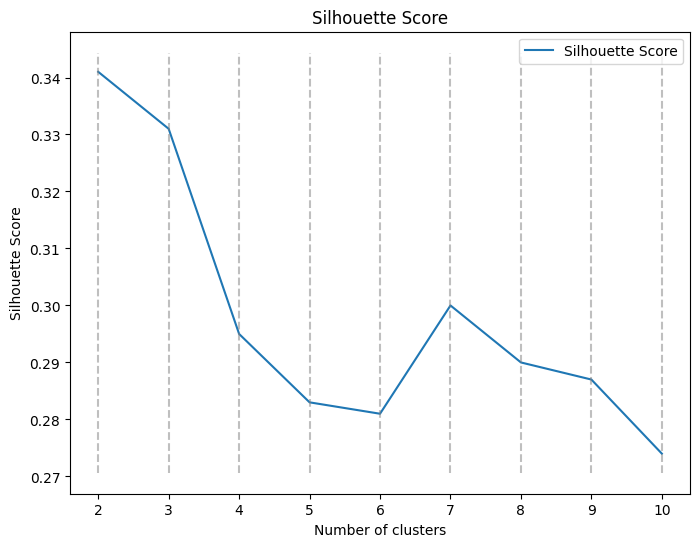

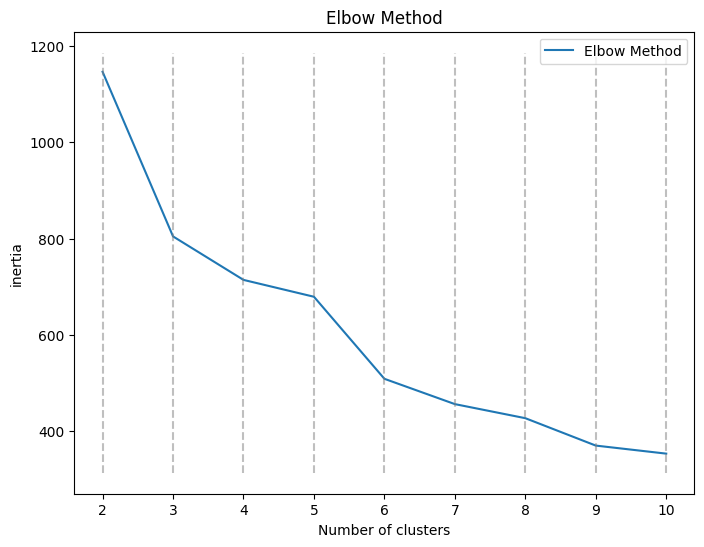

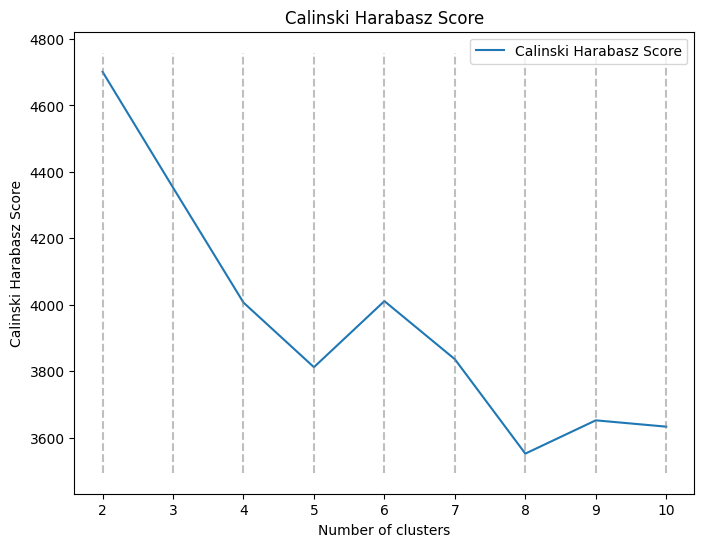

Word2vec with Kmeans excluding words with frequent less than 0.25
   ch_score  sil_score  n_clusters
0  4701.271      0.341           2
1  4352.733      0.331           3
2  4006.662      0.295           4
3  3812.258      0.283           5
4  4011.028      0.281           6
5  3836.191      0.300           7
6  3551.967      0.290           8
7  3652.175      0.287           9
8  3633.152      0.274          10


In [ ]:
result_table_gpre= test_number_of_clusters_gensim_kmeans(df['p_text'],2,10,1,0.25)

Number of data points in each cluster:
Cluster 1: 4948
Cluster 2: 3001
Number of data points in each cluster:
Cluster 1: 5664
Cluster 2: 1956
Cluster 3: 329
Number of data points in each cluster:
Cluster 1: 329
Cluster 2: 4122
Cluster 3: 648
Cluster 4: 2850
Number of data points in each cluster:
Cluster 1: 647
Cluster 2: 2447
Cluster 3: 329
Cluster 4: 2644
Cluster 5: 1882
Number of data points in each cluster:
Cluster 1: 2268
Cluster 2: 2123
Cluster 3: 521
Cluster 4: 329
Cluster 5: 1212
Cluster 6: 1496
Number of data points in each cluster:
Cluster 1: 1736
Cluster 2: 937
Cluster 3: 329
Cluster 4: 1560
Cluster 5: 1941
Cluster 6: 430
Cluster 7: 1016
Number of data points in each cluster:
Cluster 1: 329
Cluster 2: 1547
Cluster 3: 848
Cluster 4: 1307
Cluster 5: 1345
Cluster 6: 337
Cluster 7: 800
Cluster 8: 1436
Number of data points in each cluster:
Cluster 1: 459
Cluster 2: 1609
Cluster 3: 329
Cluster 4: 973
Cluster 5: 1354
Cluster 6: 285
Cluster 7: 572
Cluster 8: 1321
Cluster 9: 1047
Num

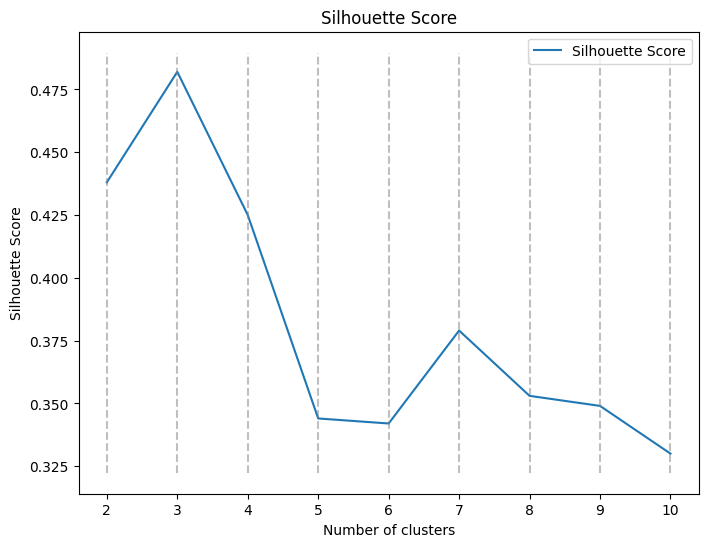

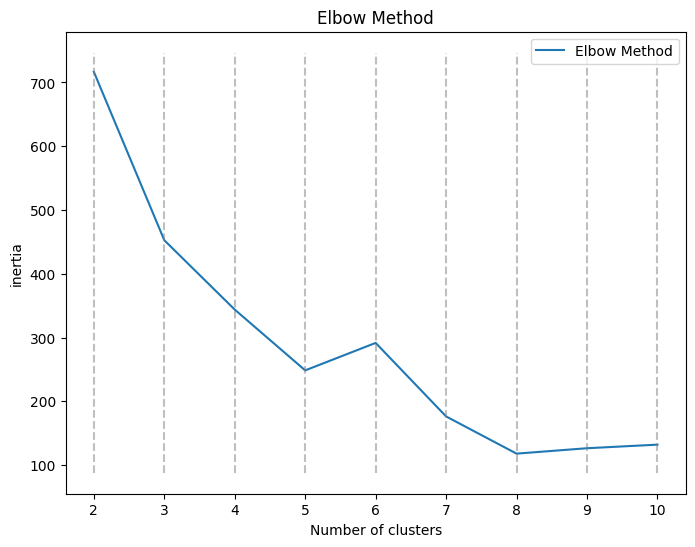

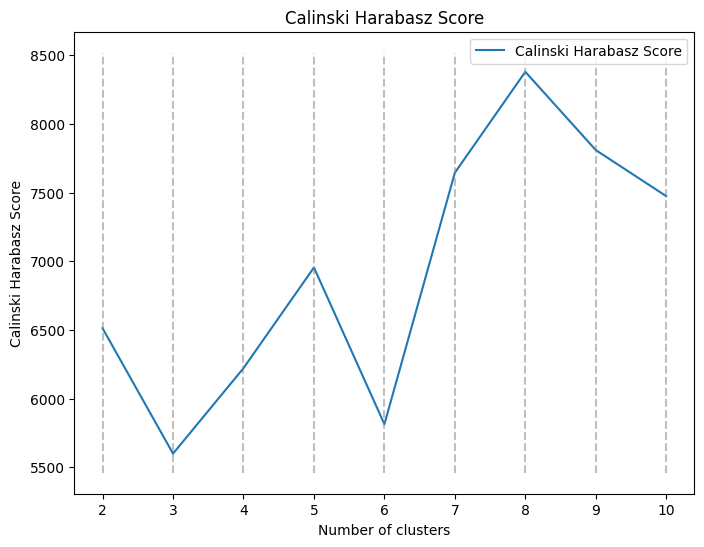

Word2vec with Kmeans excluding words with frequent less than 0.35
   ch_score  sil_score  n_clusters
0  6512.370      0.438           2
1  5599.741      0.482           3
2  6222.288      0.425           4
3  6955.270      0.344           5
4  5814.132      0.342           6
5  7645.277      0.379           7
6  8380.232      0.353           8
7  7810.394      0.349           9
8  7474.869      0.330          10


In [ ]:
result_table_gpre= test_number_of_clusters_gensim_kmeans(df['p_text'],2,10,1,0.35)

Number of data points in each cluster:
Cluster 1: 6680
Cluster 2: 1269
Number of data points in each cluster:
Cluster 1: 6434
Cluster 2: 691
Cluster 3: 824
Number of data points in each cluster:
Cluster 1: 3855
Cluster 2: 691
Cluster 3: 584
Cluster 4: 2819
Number of data points in each cluster:
Cluster 1: 3794
Cluster 2: 691
Cluster 3: 2321
Cluster 4: 364
Cluster 5: 779
Number of data points in each cluster:
Cluster 1: 1638
Cluster 2: 691
Cluster 3: 2056
Cluster 4: 321
Cluster 5: 2731
Cluster 6: 512
Number of data points in each cluster:
Cluster 1: 1923
Cluster 2: 691
Cluster 3: 298
Cluster 4: 1584
Cluster 5: 1131
Cluster 6: 506
Cluster 7: 1816
Number of data points in each cluster:
Cluster 1: 258
Cluster 2: 1106
Cluster 3: 691
Cluster 4: 1319
Cluster 5: 296
Cluster 6: 1937
Cluster 7: 570
Cluster 8: 1772
Number of data points in each cluster:
Cluster 1: 1510
Cluster 2: 691
Cluster 3: 261
Cluster 4: 878
Cluster 5: 1225
Cluster 6: 311
Cluster 7: 946
Cluster 8: 590
Cluster 9: 1537
Number 

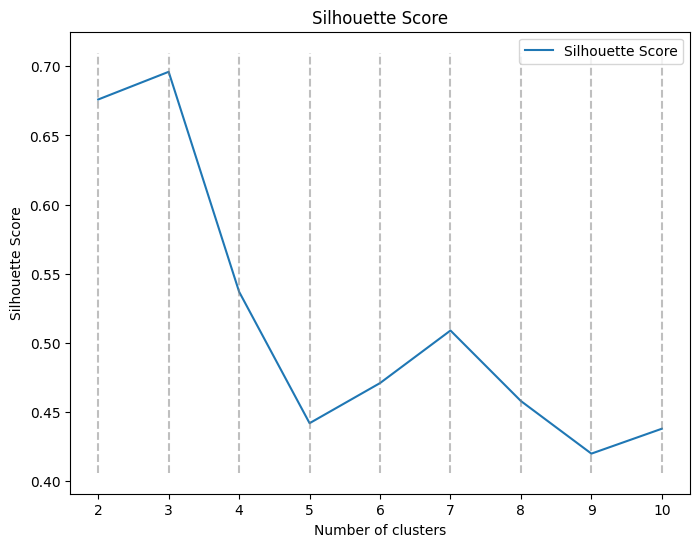

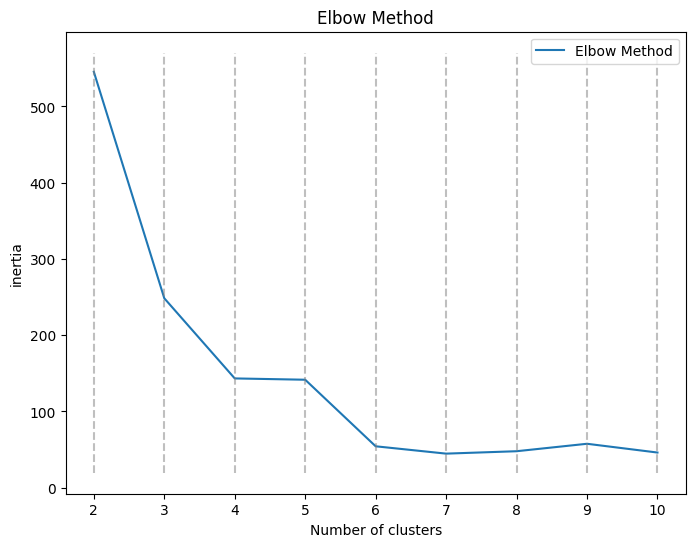

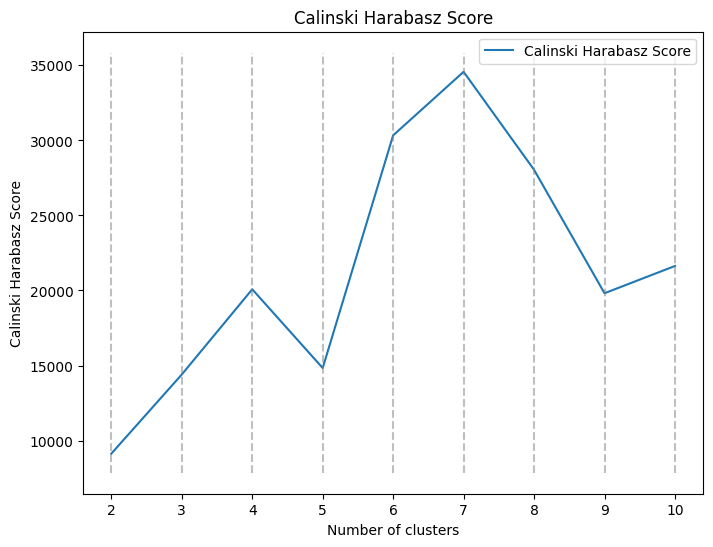

Word2vec with Kmeans excluding words with frequent less than 0.45
    ch_score  sil_score  n_clusters
0   9131.346      0.676           2
1  14403.999      0.696           3
2  20080.222      0.537           4
3  14835.931      0.442           5
4  30336.481      0.471           6
5  34568.957      0.509           7
6  28041.662      0.458           8
7  19817.094      0.420           9
8  21633.147      0.438          10


In [ ]:
result_table_gpre= test_number_of_clusters_gensim_kmeans(df['p_text'],2,10,1,0.45)

Cluster Counts:
Cluster -1: 7285 points
Cluster 1: 335 points
Cluster 0: 329 points
Cluster Counts:
Cluster 0: 5486 points
Cluster -1: 1883 points
Cluster 1: 329 points
Cluster 2: 251 points
Cluster Counts:
Cluster 0: 6860 points
Cluster -1: 760 points
Cluster 1: 329 points
Cluster Counts:
Cluster 0: 7466 points
Cluster -1: 154 points
Cluster 1: 329 points


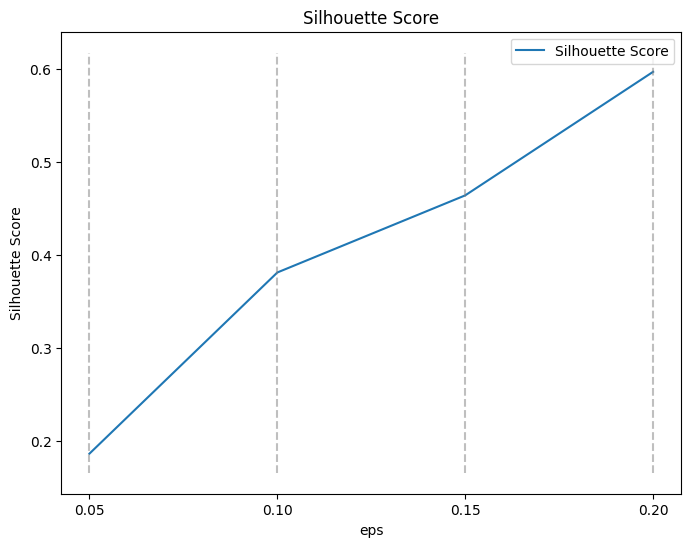

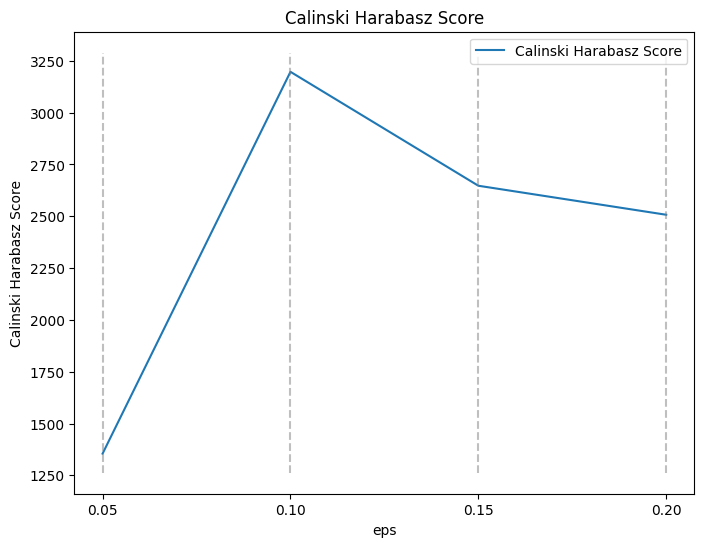

Word2vec with DBscan excluding words with frequent less than 0.35 using min_samples equal to 250
      ch_score sil_score   eps
0  (1354.656,)  (0.186,)  0.05
1  (3196.733,)  (0.381,)  0.10
2  (2647.096,)  (0.464,)  0.15
3  (2507.087,)  (0.597,)  0.20


,ch_score,sil_score,eps
0,"(1354.656,)","(0.186,)",0.05
1,"(3196.733,)","(0.381,)",0.10
2,"(2647.096,)","(0.464,)",0.15
3,"(2507.087,)","(0.597,)",0.20


In [ ]:
test_for_differnt_eps_gensim_dbscan(text_data=df['p_text'],eps_values=[0.05,0.10,0.15,0.20],word2vec_word_min_count_percentage=0.35,min_samples=250)

Cluster Counts:
Cluster 0: 5470 points
Cluster -1: 1788 points
Cluster 1: 691 points
Cluster Counts:
Cluster 0: 6685 points
Cluster -1: 573 points
Cluster 1: 691 points
Cluster Counts:
Cluster 0: 6996 points
Cluster 2: 262 points
Cluster 1: 691 points
Cluster Counts:
Cluster 0: 7258 points
Cluster 1: 691 points


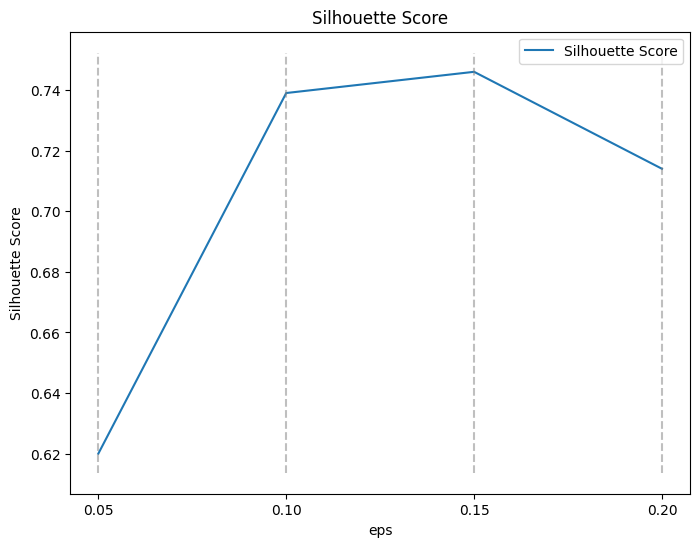

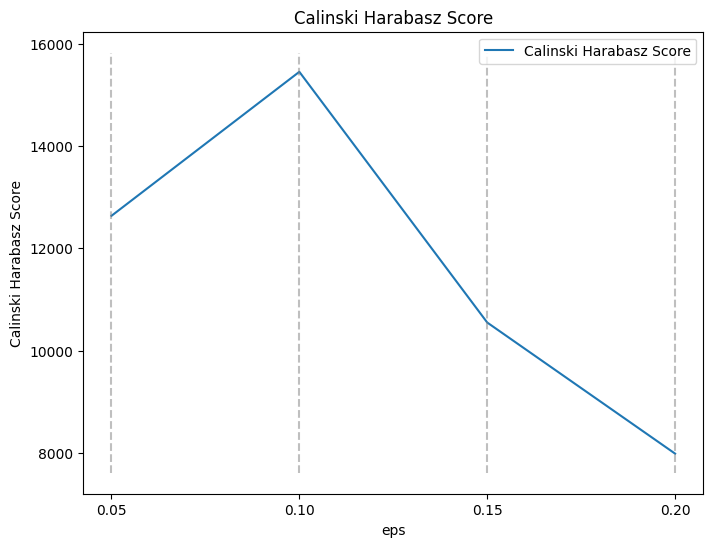

Word2vec with DBscan excluding words with frequent less than 0.45 using min_samples equal to 250
       ch_score sil_score   eps
0  (12635.296,)   (0.62,)  0.05
1  (15453.228,)  (0.739,)  0.10
2  (10547.787,)  (0.746,)  0.15
3   (7982.354,)  (0.714,)  0.20


,ch_score,sil_score,eps
0,"(12635.296,)","(0.62,)",0.05
1,"(15453.228,)","(0.739,)",0.10
2,"(10547.787,)","(0.746,)",0.15
3,"(7982.354,)","(0.714,)",0.20


In [ ]:
test_for_differnt_eps_gensim_dbscan(text_data=df['p_text'],eps_values=[0.05,0.10,0.15,0.20],word2vec_word_min_count_percentage=0.45,min_samples=250)

Number of data points in each cluster:
Cluster 1: 4112
Cluster 2: 3837
Number of data points in each cluster:
Cluster 1: 3158
Cluster 2: 3511
Cluster 3: 1280
Number of data points in each cluster:
Cluster 1: 2758
Cluster 2: 1555
Cluster 3: 2448
Cluster 4: 1188
Number of data points in each cluster:
Cluster 1: 1839
Cluster 2: 1419
Cluster 3: 1791
Cluster 4: 1762
Cluster 5: 1138
Number of data points in each cluster:
Cluster 1: 1765
Cluster 2: 1753
Cluster 3: 691
Cluster 4: 1710
Cluster 5: 1368
Cluster 6: 662
Number of data points in each cluster:
Cluster 1: 660
Cluster 2: 1641
Cluster 3: 1363
Cluster 4: 658
Cluster 5: 666
Cluster 6: 1497
Cluster 7: 1464
Number of data points in each cluster:
Cluster 1: 976
Cluster 2: 589
Cluster 3: 1291
Cluster 4: 1637
Cluster 5: 854
Cluster 6: 636
Cluster 7: 621
Cluster 8: 1345
Number of data points in each cluster:
Cluster 1: 923
Cluster 2: 1042
Cluster 3: 611
Cluster 4: 990
Cluster 5: 1056
Cluster 6: 630
Cluster 7: 798
Cluster 8: 1279
Cluster 9: 620


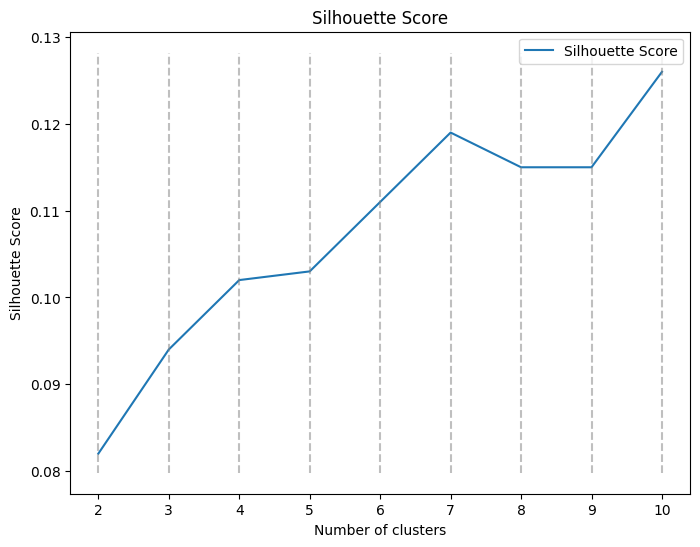

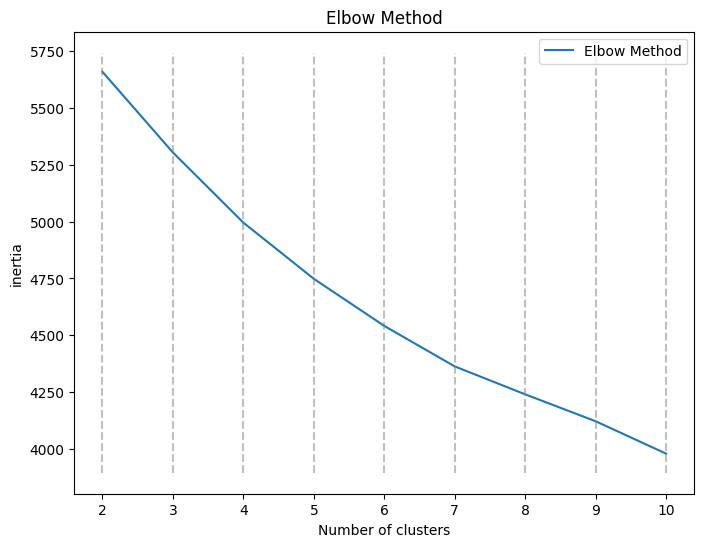

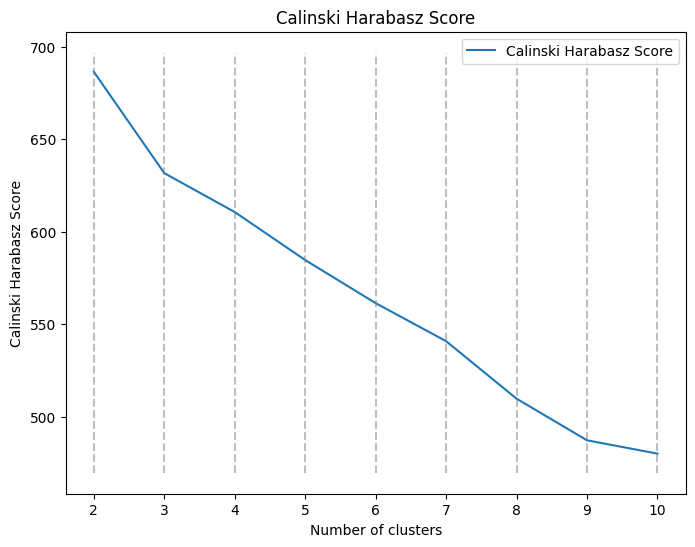

tfidf with kmeans using  min_df equal to 0.15
   ch_score  sil_score  n_clusters
0   686.528      0.082           2
1   631.737      0.094           3
2   610.692      0.102           4
3   584.732      0.103           5
4   561.437      0.111           6
5   540.863      0.119           7
6   509.775      0.115           8
7   487.263      0.115           9
8   480.061      0.126          10


,ch_score,sil_score,n_clusters
0,686.528,0.082,2
1,631.737,0.094,3
2,610.692,0.102,4
3,584.732,0.103,5
4,561.437,0.111,6
5,540.863,0.119,7
6,509.775,0.115,8
7,487.263,0.115,9
8,480.061,0.126,10


In [ ]:
test_number_of_clusters_tfidf_kmeans(text_data=df['p_text'],start_number=2, end_number=10, step=1,min_df=0.15,max_df=0.9)

Number of data points in each cluster:
Cluster 1: 3406
Cluster 2: 2581
Cluster 3: 1962
Number of data points in each cluster:
Cluster 1: 1918
Cluster 2: 1713
Cluster 3: 2174
Cluster 4: 2144
Number of data points in each cluster:
Cluster 1: 1378
Cluster 2: 1971
Cluster 3: 1819
Cluster 4: 990
Cluster 5: 1791
Number of data points in each cluster:
Cluster 1: 1178
Cluster 2: 1707
Cluster 3: 1512
Cluster 4: 1403
Cluster 5: 967
Cluster 6: 1182
Number of data points in each cluster:
Cluster 1: 1024
Cluster 2: 1603
Cluster 3: 850
Cluster 4: 1295
Cluster 5: 1137
Cluster 6: 1146
Cluster 7: 894
Number of data points in each cluster:
Cluster 1: 958
Cluster 2: 797
Cluster 3: 1122
Cluster 4: 886
Cluster 5: 877
Cluster 6: 1085
Cluster 7: 1295
Cluster 8: 929
Number of data points in each cluster:
Cluster 1: 785
Cluster 2: 909
Cluster 3: 1295
Cluster 4: 893
Cluster 5: 1080
Cluster 6: 526
Cluster 7: 965
Cluster 8: 775
Cluster 9: 721
Number of data points in each cluster:
Cluster 1: 818
Cluster 2: 838
Cl

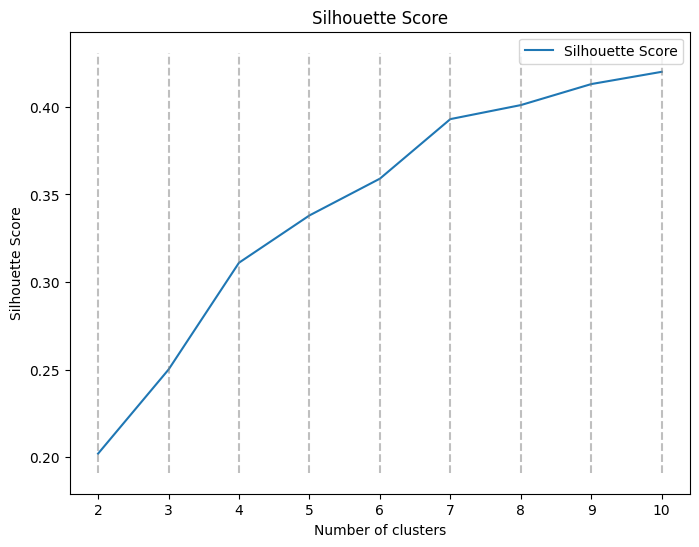

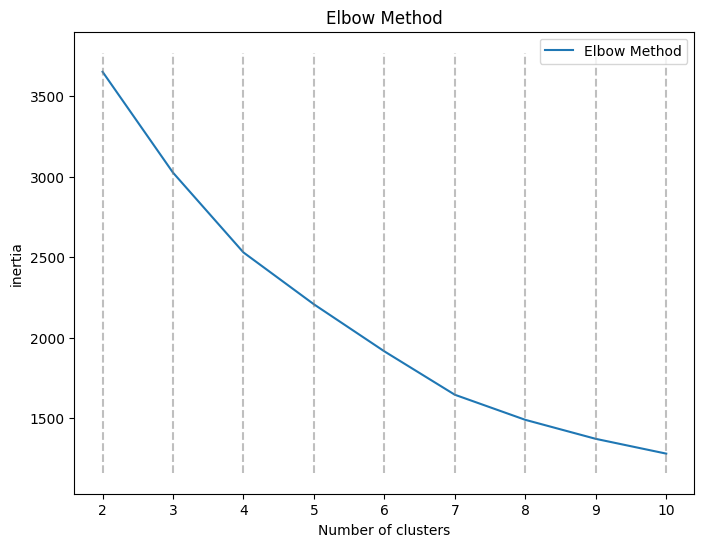

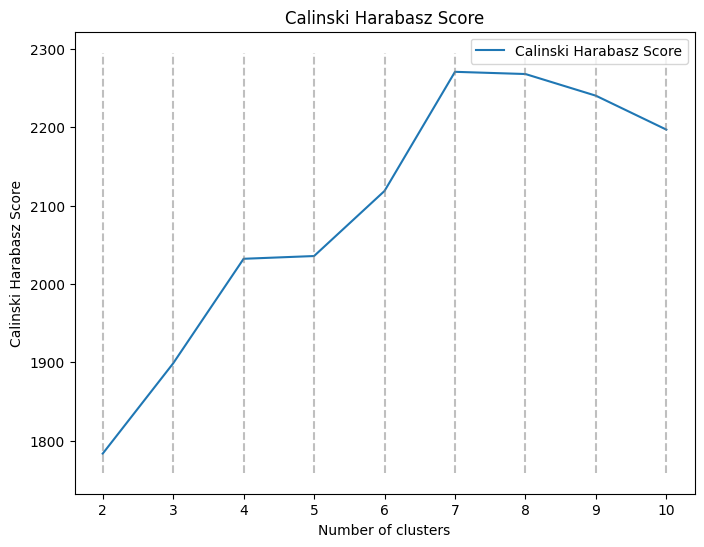

tfidf with kmeans using  min_df equal to 0.25
   ch_score  sil_score  n_clusters
0  1783.359      0.202           2
1  1898.648      0.250           3
2  2032.159      0.311           4
3  2035.666      0.338           5
4  2118.770      0.359           6
5  2270.898      0.393           7
6  2268.069      0.401           8
7  2240.389      0.413           9
8  2197.095      0.420          10


,ch_score,sil_score,n_clusters
0,1783.359,0.202,2
1,1898.648,0.250,3
2,2032.159,0.311,4
3,2035.666,0.338,5
4,2118.770,0.359,6
5,2270.898,0.393,7
6,2268.069,0.401,8
7,2240.389,0.413,9
8,2197.095,0.420,10


In [ ]:
test_number_of_clusters_tfidf_kmeans(text_data=df['p_text'],start_number=2, end_number=10, step=1,min_df=0.25,max_df=0.9)

Number of data points in each cluster:
Cluster 1: 4266
Cluster 2: 3683
Number of data points in each cluster:
Cluster 1: 3029
Cluster 2: 2842
Cluster 3: 2078
Number of data points in each cluster:
Cluster 1: 1985
Cluster 2: 2008
Cluster 3: 2166
Cluster 4: 1790
Number of data points in each cluster:
Cluster 1: 1397
Cluster 2: 2008
Cluster 3: 1793
Cluster 4: 1767
Cluster 5: 984
Number of data points in each cluster:
Cluster 1: 1467
Cluster 2: 2008
Cluster 3: 1240
Cluster 4: 1052
Cluster 5: 1147
Cluster 6: 1035
Number of data points in each cluster:
Cluster 1: 594
Cluster 2: 1405
Cluster 3: 926
Cluster 4: 2008
Cluster 5: 1077
Cluster 6: 936
Cluster 7: 1003
Number of data points in each cluster:
Cluster 1: 1368
Cluster 2: 576
Cluster 3: 2008
Cluster 4: 791
Cluster 5: 734
Cluster 6: 1127
Cluster 7: 613
Cluster 8: 732
Number of data points in each cluster:
Cluster 1: 2008
Cluster 2: 1003
Cluster 3: 1370
Cluster 4: 698
Cluster 5: 791
Cluster 6: 492
Cluster 7: 288
Cluster 8: 537
Cluster 9: 762

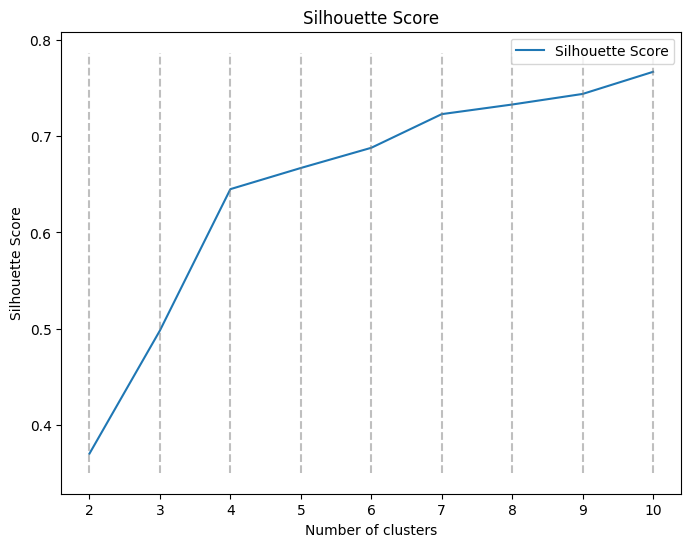

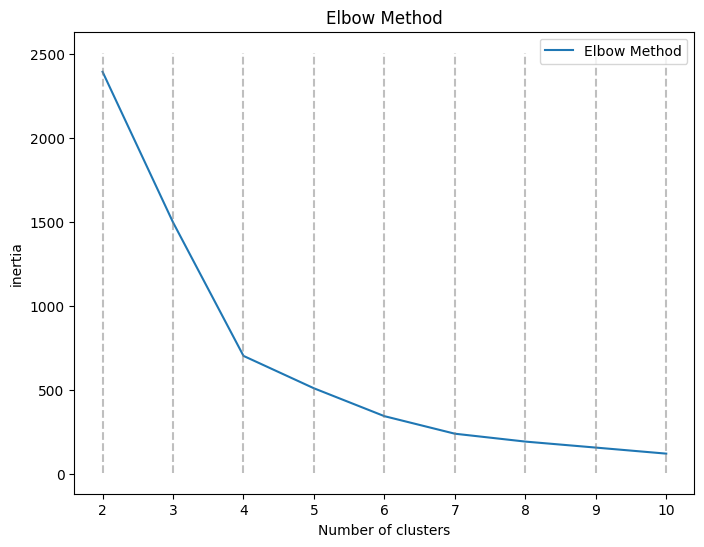

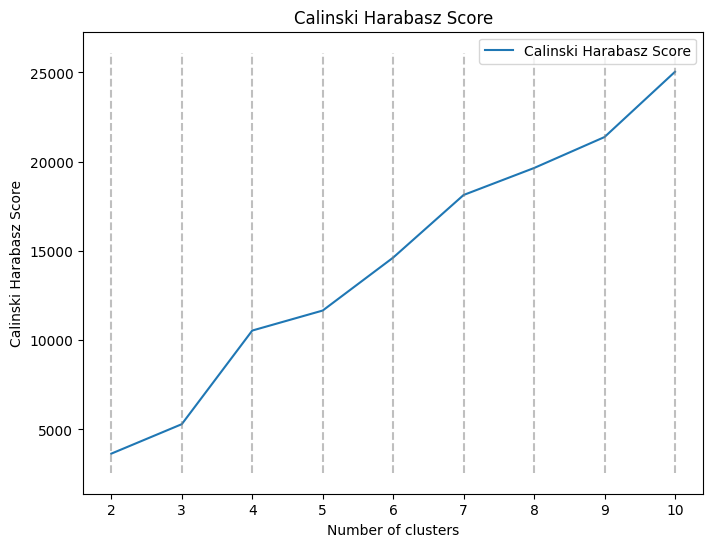

tfidf with kmeans using  min_df equal to 0.35
    ch_score  sil_score  n_clusters
0   3643.954      0.370           2
1   5294.151      0.498           3
2  10538.777      0.645           4
3  11659.656      0.667           5
4  14625.324      0.688           6
5  18133.294      0.723           7
6  19643.911      0.733           8
7  21378.698      0.744           9
8  25032.923      0.767          10


,ch_score,sil_score,n_clusters
0,3643.954,0.370,2
1,5294.151,0.498,3
2,10538.777,0.645,4
3,11659.656,0.667,5
4,14625.324,0.688,6
5,18133.294,0.723,7
6,19643.911,0.733,8
7,21378.698,0.744,9
8,25032.923,0.767,10


In [ ]:
test_number_of_clusters_tfidf_kmeans(text_data=df['p_text'],start_number=2, end_number=10, step=1,min_df=0.35,max_df=0.9)

Cluster Counts:
Cluster -1: 7949 points
Cluster Counts:
Cluster -1: 7949 points
Cluster Counts:
Cluster -1: 7949 points
Cluster Counts:
Cluster -1: 7949 points


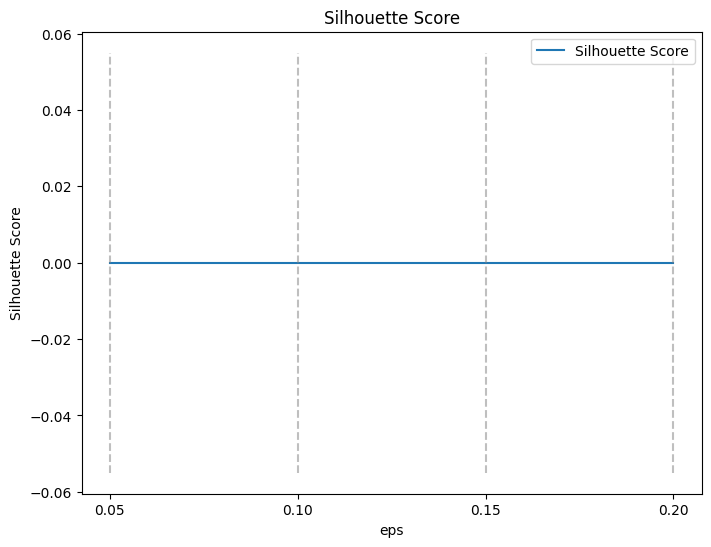

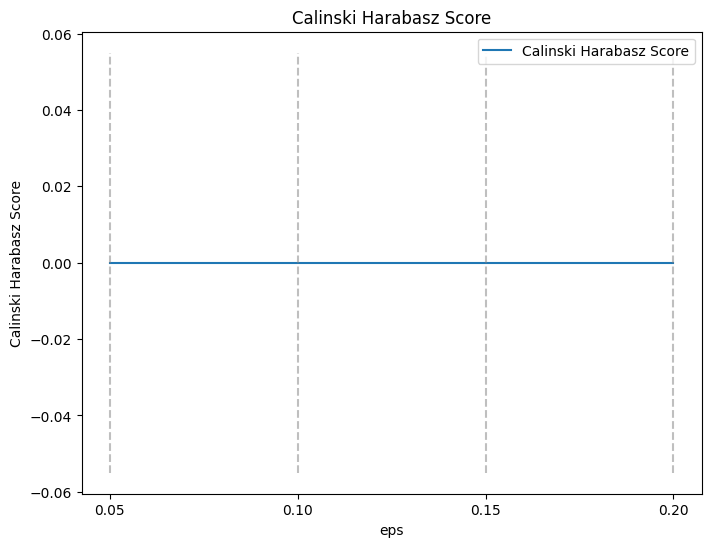

tfidf with DBscan using min_samples equal to 250 and min_df equal to 0.15
   ch_score  sil_score   eps
0         0          0  0.05
1         0          0  0.10
2         0          0  0.15
3         0          0  0.20


,ch_score,sil_score,eps
0,0,0,0.05
1,0,0,0.10
2,0,0,0.15
3,0,0,0.20


In [ ]:
test_for_differnt_eps_tfidf_dbscan(text_data=df['p_text'],eps_values=[0.05,0.10,0.15,0.20],min_df=0.15,max_df=0.9,min_samples=250)

Cluster Counts:
Cluster -1: 5742 points
Cluster 0: 281 points
Cluster 1: 631 points
Cluster 2: 1295 points
Cluster Counts:
Cluster -1: 5742 points
Cluster 0: 281 points
Cluster 1: 631 points
Cluster 2: 1295 points
Cluster Counts:
Cluster -1: 5741 points
Cluster 0: 282 points
Cluster 1: 631 points
Cluster 2: 1295 points
Cluster Counts:
Cluster -1: 5416 points
Cluster 0: 285 points
Cluster 1: 648 points
Cluster 3: 255 points
Cluster 2: 1295 points
Cluster 4: 50 points


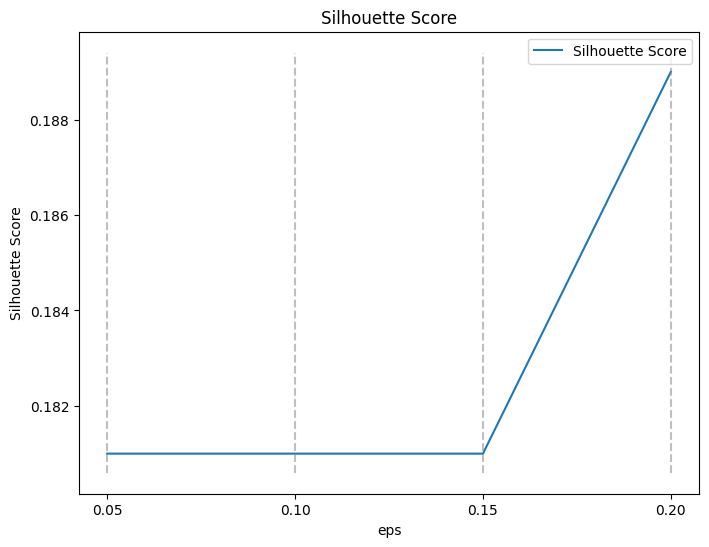

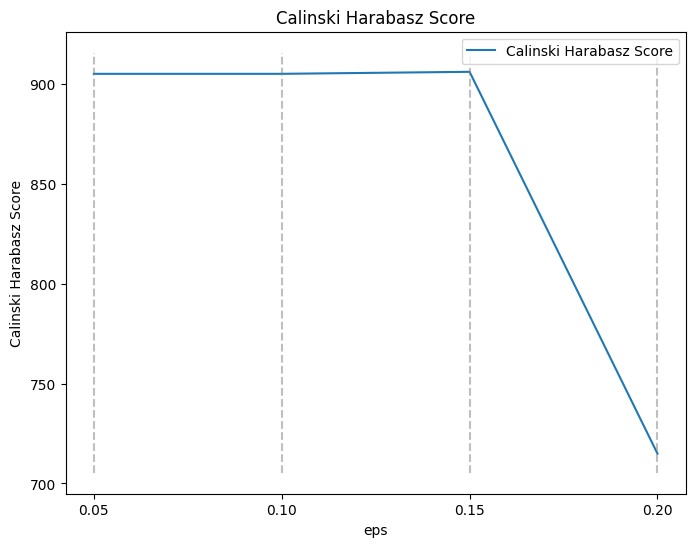

tfidf with DBscan using min_samples equal to 250 and min_df equal to 0.25
     ch_score sil_score   eps
0  (905.233,)  (0.181,)  0.05
1  (905.233,)  (0.181,)  0.10
2   (906.24,)  (0.181,)  0.15
3  (714.946,)  (0.189,)  0.20


,ch_score,sil_score,eps
0,"(905.233,)","(0.181,)",0.05
1,"(905.233,)","(0.181,)",0.10
2,"(906.24,)","(0.181,)",0.15
3,"(714.946,)","(0.189,)",0.20


In [ ]:
test_for_differnt_eps_tfidf_dbscan(text_data=df['p_text'],eps_values=[0.05,0.10,0.15,0.20],min_df=0.25,max_df=0.9,min_samples=250)

Cluster Counts:
Cluster 0: 511 points
Cluster 1: 296 points
Cluster -1: 2676 points
Cluster 2: 1262 points
Cluster 3: 507 points
Cluster 4: 689 points
Cluster 5: 2008 points
Cluster Counts:
Cluster 0: 511 points
Cluster 1: 377 points
Cluster -1: 2280 points
Cluster 2: 1262 points
Cluster 3: 566 points
Cluster 4: 690 points
Cluster 5: 2008 points
Cluster 6: 255 points
Cluster Counts:
Cluster 0: 859 points
Cluster 1: 911 points
Cluster -1: 1509 points
Cluster 2: 1262 points
Cluster 3: 626 points
Cluster 4: 690 points
Cluster 5: 2008 points
Cluster 6: 84 points
Cluster Counts:
Cluster 0: 2477 points
Cluster 1: 1835 points
Cluster -1: 392 points
Cluster 2: 691 points
Cluster 3: 2008 points
Cluster 4: 546 points


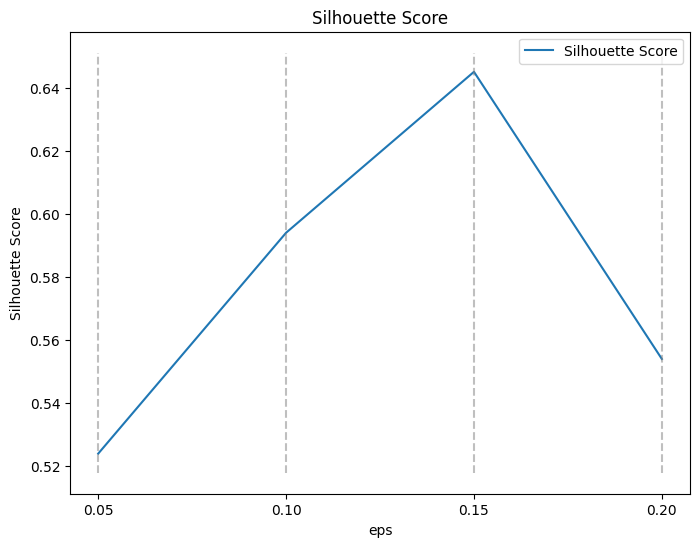

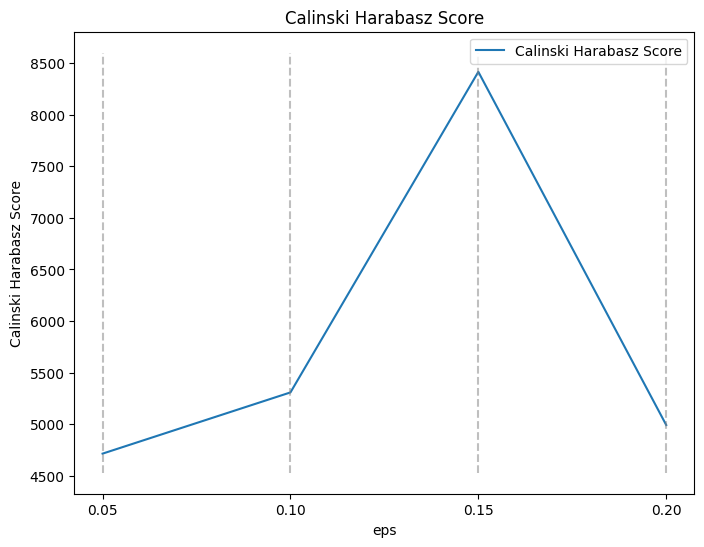

tfidf with DBscan using min_samples equal to 250 and min_df equal to 0.35
      ch_score sil_score   eps
0  (4713.092,)  (0.524,)  0.05
1   (5306.93,)  (0.594,)  0.10
2  (8416.732,)  (0.645,)  0.15
3  (4990.621,)  (0.554,)  0.20


,ch_score,sil_score,eps
0,"(4713.092,)","(0.524,)",0.05
1,"(5306.93,)","(0.594,)",0.10
2,"(8416.732,)","(0.645,)",0.15
3,"(4990.621,)","(0.554,)",0.20


In [ ]:
test_for_differnt_eps_tfidf_dbscan(text_data=df['p_text'],eps_values=[0.05,0.10,0.15,0.20],min_df=0.35,max_df=0.9,min_samples=250)